# Öncelikle Fotoğraflar üzerinde çalışacağız

### Fotoğrafta beyaz olan yerler haricini karartacağız bu sayede şeritler dahada belli olacak ve şerit üzerinde üçgen çizerek  şeriti takip etmesini sağlayacağız

# Canny Edge Detection

## Öncelikle bazı renkleri seçelim. Örneğin: Yol şeritleri genellikle beyaz renkte olur ve beyazın RGB değeri (255, 255, 255)'tir. Burada red_threshold, green_threshold ve blue_threshold değişkenlerinde bir renk eşiği tanımlayacağız ve rgb_threshold değişkenini bu değerlerle dolduracağız. Bu vektör, seçimimde izin vereceğim kırmızı, yeşil ve mavi (R, G, B) için minimum değerleri içerir.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

image = mpimg.imread('/home/lorddeniz/Masaüstü/Road_lane/test_images/solidWhiteRight.jpg')

#(yükseklik, genişlik, kanallar)
ysize = image.shape[0]
xsize = image.shape[1]

color_select = np.copy(image)
line_image = np.copy(image)

#renk eşiği belirlemek renklerin minumum eşik değeri 200 olarak belirlendi
red_threshold = 200 
green_threshold = 200
blue_threshold = 200



rgb_threshold = [red_threshold, green_threshold, blue_threshold] #[200, 200, 200]

#eşik değerinden küçük olan pikseller True, diğerleri False olacak şekilde bir boolean dizisi elde edilir
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])

#thresholds koşulunu karşılayan piksellerin renk değerlerini (0, 0, 0) (siyah) olarak ayarla
color_select[thresholds] = [0,0,0]


# Region Masking

### Ön kameranın görüntüyü çeken pozisyonda sabit bir şekilde araca monte edildiğini varsayacağım, böylece yol şeritleri her zaman görüntünün aynı genel bölgesinde görünecektir. Bu avantajdan yararlanarak, renk seçimi için yalnızca yol şeritlerini bulmayı beklediğimiz bölgedeki pikselleri dikkate alma kriteri ekleyeceğim.

### Aşağıdaki koda göz atın. left_bottom, right_bottom ve apex değişkenleri, renk seçimim için korumak istediğim üçgen bölgenin köşelerini temsil ederken, diğer her şeyi maskelemektedir. Burada en basit durumu göstermek için üçgen bir maske kullanıyorum, ancak bir dörtgen kullanabiliriz ve prensipte herhangi bir çokgeni kullanabiliriz.

In [2]:
left_bottom = [100, 539] #Sol alt köşedeki noktanın koordinatları.
right_bottom = [950, 539] #Sağ alt köşedeki noktanın koordinatları.
apex = [480, 290] #Tepe noktasının koordinatları.

# Sol, sağ ve alt kenarlar arasındaki doğrusal uyumları hesapla
#np.polyfit fonksiyonu, verilen veri noktalarına en iyi uyacak polinomun katsayılarını döndürür. 
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Görüntü üzerinde bir ızgara oluştur ve bölge eşiklerini tanımla
# bir görüntü üzerinde belirli bir bölgeyi seçmek
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX * fit_left[0] + fit_left[1])) & \
                    (YY > (XX * fit_right[0] + fit_right[1])) & \
                    (YY < (XX * fit_bottom[0] + fit_bottom[1]))

# Renk eşiklerini ve bölge eşiklerini kullanarak işlem yap
# Renk eşiklerini sağlamayan veya bölge eşiklerini sağlamayan pikselleri siyah renge dönüştür
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]

# Renk eşiklerini sağlamayan ancak bölge eşiklerini sağlayan pikselleri yeşil renkle işaretle
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]





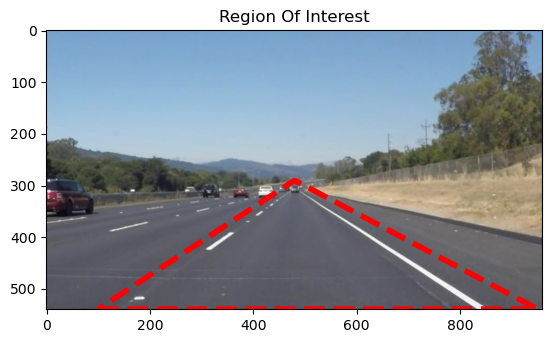

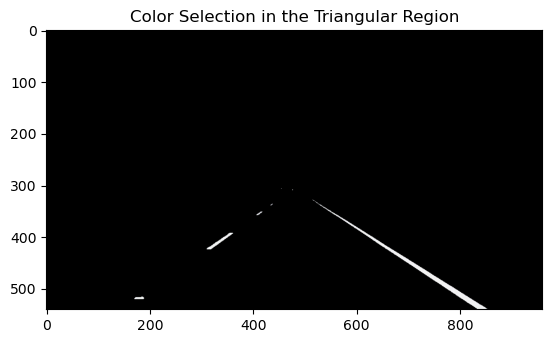

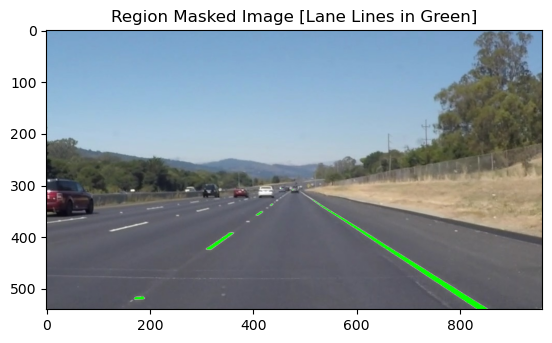

In [3]:
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(color_select)
plt.title("Color Selection in the Triangular Region")
plt.show()
plt.imshow(line_image)
plt.title("Region Masked Image [Lane Lines in Green]")
plt.show()

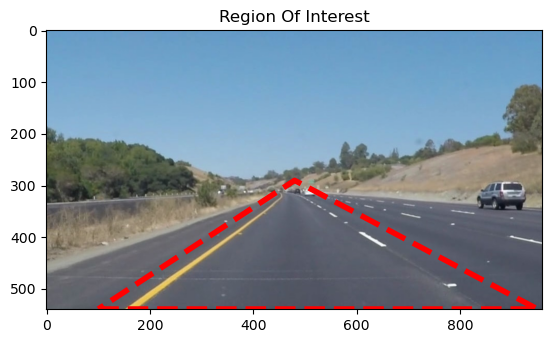

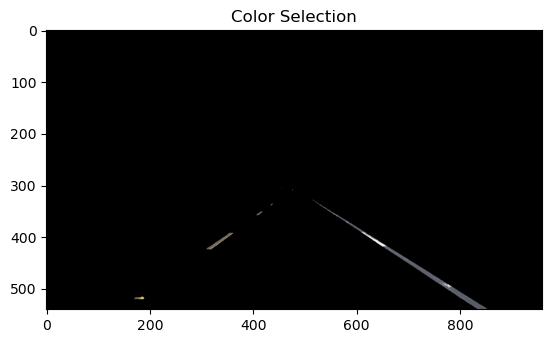

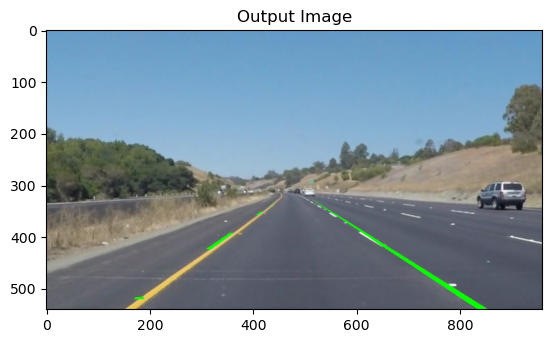

In [4]:
# Görüntüyü yükle
image = mpimg.imread('/home/lorddeniz/Masaüstü/Road_lane/test_images/solidYellowCurve.jpg')


ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)



# Görüntünün boyutlarını al
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))

# Belirli bölge için eşikleri tanımla
region_thresholds = (YY > (XX * fit_left[0] + fit_left[1])) & \
                    (YY > (XX * fit_right[0] + fit_right[1])) & \
                    (YY < (XX * fit_bottom[0] + fit_bottom[1]))

# Renk eşiklerine göre seçim yap ve siyah (0, 0, 0) renk ataması yap
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]

# Hem renk hem de bölge seçimlerinin sağlandığı yerlerde pikselleri kırmızı (9, 255, 0) yap
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]

# Görüntüyü göster ve bölge ile renk seçimlerini göster
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)  # Belirtilen bölgeyi kırmızı kesik çizgi ile göster
plt.title("Region Of Interest")
plt.show()

# Renk seçimlerini göster
plt.imshow(color_select)
plt.title("Color Selection")
plt.show()

# Çıktı görüntüsünü göster
plt.imshow(line_image)
plt.title("Output Image")
plt.show()


# Canny Edge Detection
### Şimdi gri tonlamalı görüntüye Canny algoritmasını uyguluyoruz ve çıktımız edges adlı başka bir görüntü olacak. low_threshold ve high_threshold kenar algılama için eşik değerlerinizdir.

### Algoritma, önce high_threshold üzerindeki güçlü kenar (güçlü gradyan) piksellerini tespit edecek ve low_threshold altındaki pikselleri reddedecektir. Daha sonra, low_threshold ve high_threshold arasında kalan piksel değerleri, güçlü kenarlara bağlı oldukları sürece dahil edilecektir. Çıktı edges, tespit edilen kenarları beyaz piksellerle izleyen ve diğer her yerde siyah olan ikili bir görüntüdür. Daha fazla ayrıntı için OpenCV Canny belgelerine bakın.

### Bu parametreler için makul bir aralık ne olabilir? Bizim durumumuzda, gri tonlamaya dönüştürmek bize 8 bitlik bir görüntü bıraktı, bu nedenle her piksel 2^8 = 256 olası değeri alabilir. Dolayısıyla, piksel değerleri 0 ile 255 arasında değişir.

### Bu aralık, türevlerin (temelde, pikselden piksele değer farklarının) onlarca veya yüzlerce ölçeğinde olacağını ima eder. Bu nedenle, eşik parametreleriniz için makul bir aralık da onlarca veya yüzlerce olmalıdır.

### low_threshold ile high_threshold arasındaki oran açısından, John Canny kendisi düşükten yükseğe oranını 1:2 veya 1:3 olarak önermiştir.

### Canny'yi çalıştırmadan önce, ayrıca Gauss bulanıklaştırma (Gaussian smoothing) ekleyeceğiz. Bu, temelde, ortalama alarak gürültü ve geçici gradyanları bastırmanın bir yoludur (GaussianBlur için OpenCV belgelerine göz atın). cv2.Canny() aslında dahili olarak Gauss bulanıklaştırma uygular, ancak burada daha fazla bulanıklaştırma uygulayarak farklı bir sonuç elde edebileceğiniz için bunu ekliyoruz (ve cv2.Canny() içinde değiştirilebilir bir parametre değildir!).

### Gauss bulanıklaştırma için kernel_sizeı herhangi bir tek sayı olarak seçebilirsiniz. Daha büyük bir kernel_size, daha geniş bir alanda ortalama almayı veya yumuşatmayı ifade eder.

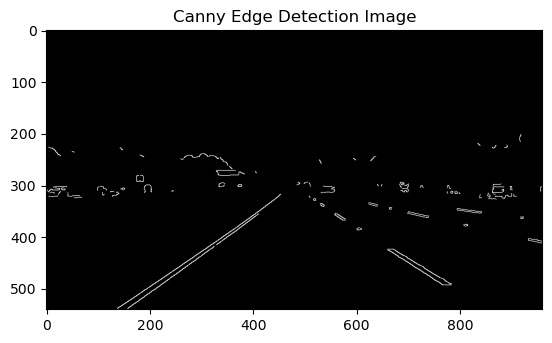

In [5]:
image3 = mpimg.imread('/home/lorddeniz/Masaüstü/Road_lane/test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image3,cv2.COLOR_RGB2GRAY)

kernel_size = 5 
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()


# Hough Dönüşümü ve Şerit Çizgilerini Algılama

### Görüntü alanında, bir çizgi x ve y olarak çizilir, ancak 1962 yılında Paul Hough, çizgileri parametre alanında temsil etme yöntemini geliştirdi ve onun onuruna bu alanı "Hough alanı" olarak adlandıracağız.

### Hough alanında, "x ve y" çizgimi bunun yerine "m ve b" olarak temsil edebilirim. Hough Dönüşümü, görüntü alanından Hough alanına yapılan dönüşümdür. Bu nedenle, görüntü alanında bir çizginin karakterizasyonu, Hough alanında (m, b) pozisyonunda tek bir nokta olacaktır.

### Görsel temsil açısından, bir çizginin Hough alanındaki temsilini anlamak, özellikle görüntü işleme ve bilgisayarla görü alanlarında güçlü bir araçtır. Hough Dönüşümü, kenar algılama ve şekil tespiti gibi görevlerde yaygın olarak kullanılır ve karmaşık sahnelerde bile güvenilir sonuçlar verebilir. Bu yöntem, özellikle çizgi, daire ve diğer basit şekillerin tespiti için etkili bir tekniktir.








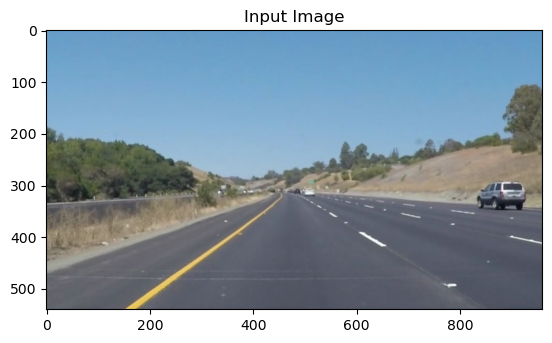

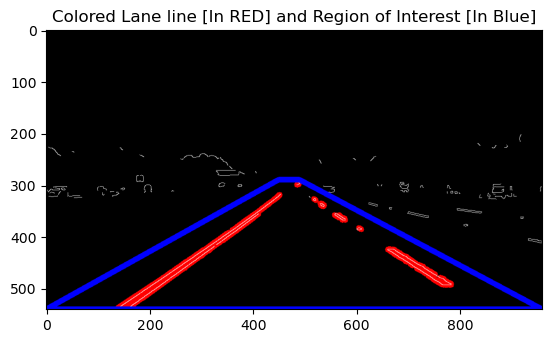

In [6]:
image4 = mpimg.imread('/home/lorddeniz/Masaüstü/Road_lane/test_images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image4,cv2.COLOR_RGB2GRAY)

# Kernel boyutunu tanımlayıp  Gaussian bulanıklaştırma uygulayalım
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size,kernel_size),0)

# Canny için parametreleri tanımlayın ve uygulayın
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# cv2.fillPoly() kullanarak maskelenmiş kenar görüntüsü oluşturacağız
mask = np.zeros_like(edges)
ignore_mask_color = 255


# Bu sefer dört kenarlı bir çokgen tanımlıyoruz
imshape = image4.shape
vertices = np.array([[(0, imshape[0]), (450, 290), (490, 290), (imshape[1], imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges,mask)


# Hough dönüşüm parametrelerini tanımlayın
# Çizim yapmak için görüntümüzle aynı boyutta bir boşluk oluşturun
rho = 1 # Hough ızgarasının piksel cinsinden mesafe çözünürlüğü
theta = np.pi / 180 # Hough ızgarasının radyan cinsinden açısal çözünürlüğü
threshold = 2 # Hough ızgara hücresindeki minimum oy (kesişim) sayısı
min_line_length = 4 # Çizgiyi oluşturan minimum piksel sayısı
max_line_gap = 5 # Bağlanabilir çizgi segmentleri arasındaki maksimum piksel boşluğu
line_image = np.copy(image) * 0 # Çizgileri çizmek için boş bir görüntü oluşturma

# Kenar tespiti yapılmış görüntüde Hough çalıştırın
# Çıktı "lines", tespit edilen çizgi segmentlerinin uç noktalarını içeren bir dizidir
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Çıktı "lines" üzerinde yineleme yapın ve boş bir görüntüye çizgiler çizin
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)


# Çizgi görüntüsü ile birleştirmek için "renkli" ikili bir görüntü oluşturun
color_edges = np.dstack((edges,edges,edges))

lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()



# Lane Detection Pipeline

Gray Scale
Gaussian Smoothing
Canny Edge Detection
Region Masking
Hough Transform
Draw Lines [Mark Lane Lines with different Color]

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grayscale(img):
    """
    Gri Tonlama dönüşümünü uygular
    Bu, yalnızca bir renk kanalı olan bir görüntü döndürecektir
    ama NOT: döndürülen görüntüyü gri tonlamalı olarak görmek için
    (gri tonlamalı görüntünüzün 'gray' olarak adlandırıldığını varsayarsak)
    plt.imshow(gray, cmap='gray') çağrısını yapmalısınız
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Bir görüntü maskesi uygular. Yalnızca vertices ile tanımlanan çokgenden oluşan görüntü bölgesini korur. 
    Görüntünün geri kalanı siyah olarak ayarlanır. vertices, tamsayı noktalarından oluşan bir numpy dizisi 
    olmalıdır.
    """
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOT: Tespit ettiğiniz çizgi segmentlerini tam şerit haritası oluşturmak için ortalama alma/ekstrapolasyon 
    yapmak istediğinizde başlangıç noktası olarak kullanmak isteyebileceğiniz fonksiyon budur 
    (raw-lines-example.mp4'te gösterilen sonuçtan P1_example.mp4'te gösterilen sonuca gitmek için).

    Eğimlerine ((y2-y1)/(x2-x1)) göre çizgi segmentlerini ayırmak gibi şeyler düşünün, bu şekilde hangi segmentlerin 
    sol çizginin ve hangilerinin sağ çizginin parçası olduğunu belirleyebilirsiniz. Daha sonra, her bir çizginin 
    pozisyonunu ortalayabilir ve şeridin üst ve alt kısımlarına ekstrapolasyon yapabilirsiniz.

    Bu fonksiyon color ve thickness ile lines çizer. Çizgiler görüntü üzerinde yerinde çizilir (görüntüyü değiştirir).
    Eğer çizgilerin yarı saydam olmasını istiyorsanız, bu fonksiyonu aşağıdaki weighted_img() 
    fonksiyonu ile birleştirmeyi düşünebilirsiniz.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image, lines):
    img = image.copy()
    poly_vertices = []
    order = [0, 1, 3, 2]

    left_lines = []  # Like /
    right_lines = []  # Like \
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                pass  # Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m, c))
                elif m >= 0:
                    right_lines.append((m, c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    for slope, intercept in [left_line, right_line]:
        # Getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1 = int(rows)  # image.shape[0]

        # Taking y2 up to 60% of actual height or 60% of y1
        y2 = int(rows * 0.6)  # int(0.6 * y1)

        # We know that the equation of a line is y = mx + c so we can write it x = (y - c) / m
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1, y1, x2, y2]]]))

    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts=np.array([poly_vertices], 'int32'), color=(0, 255, 0))
    return cv2.addWeighted(image, 0.7, img, 0.4, 0.)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    line_img = slope_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    # lines_edges = cv2.polylines(lines_edges, get_vertices(img), True, (0,0,255), 10)
    return lines_edges

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.15, rows]
    top_left = [cols * 0.45, rows * 0.6]
    bottom_right = [cols * 0.95, rows]
    top_right = [cols * 0.55, rows * 0.6]

    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver


In [8]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

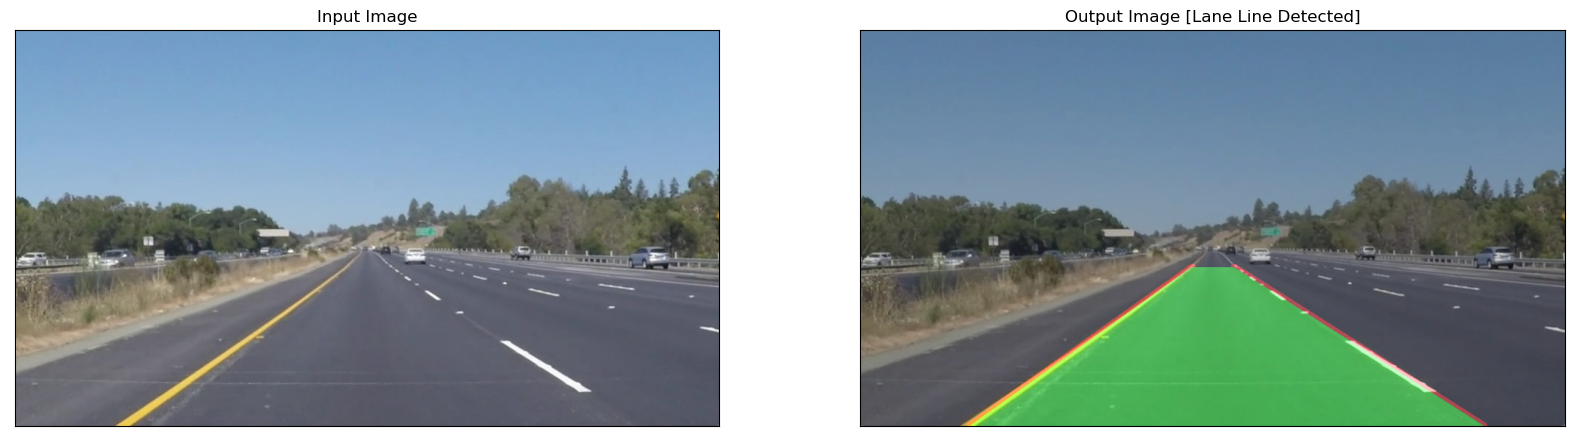

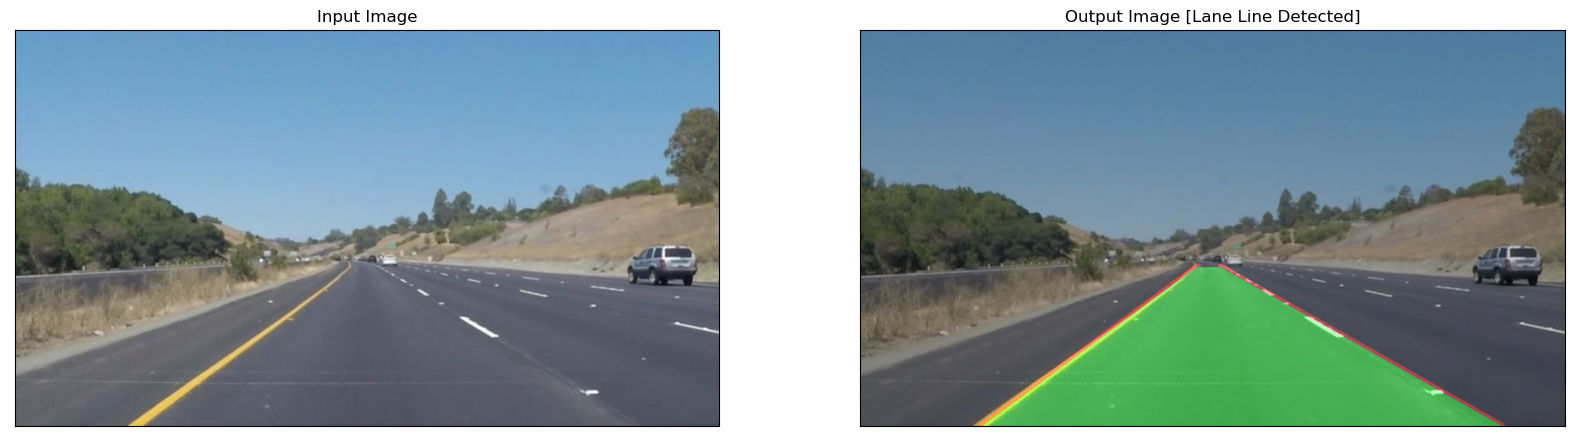

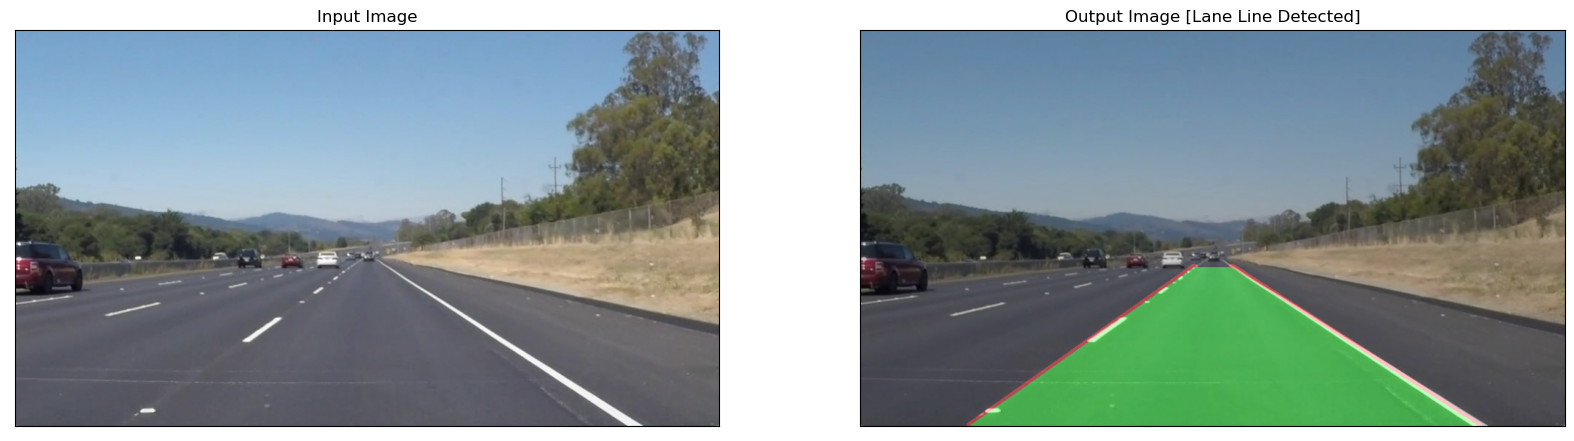

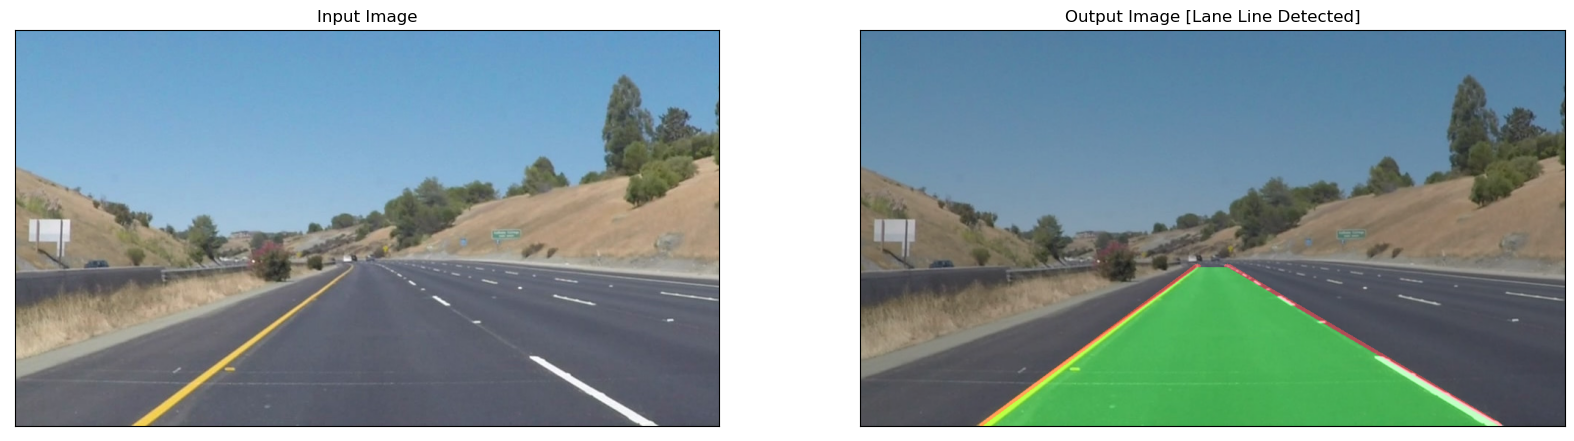

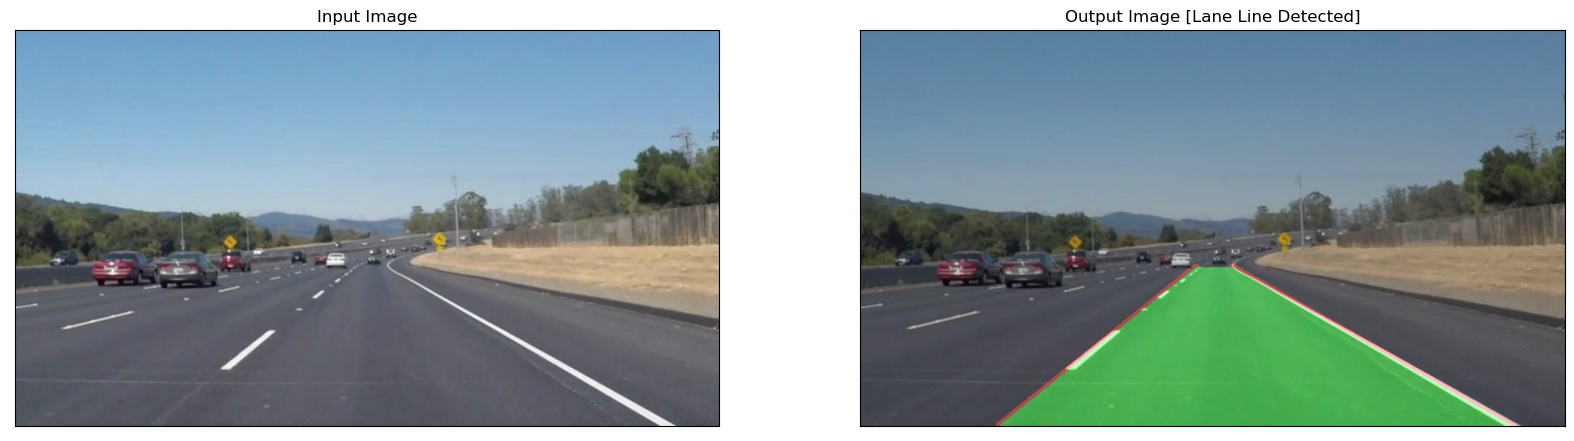

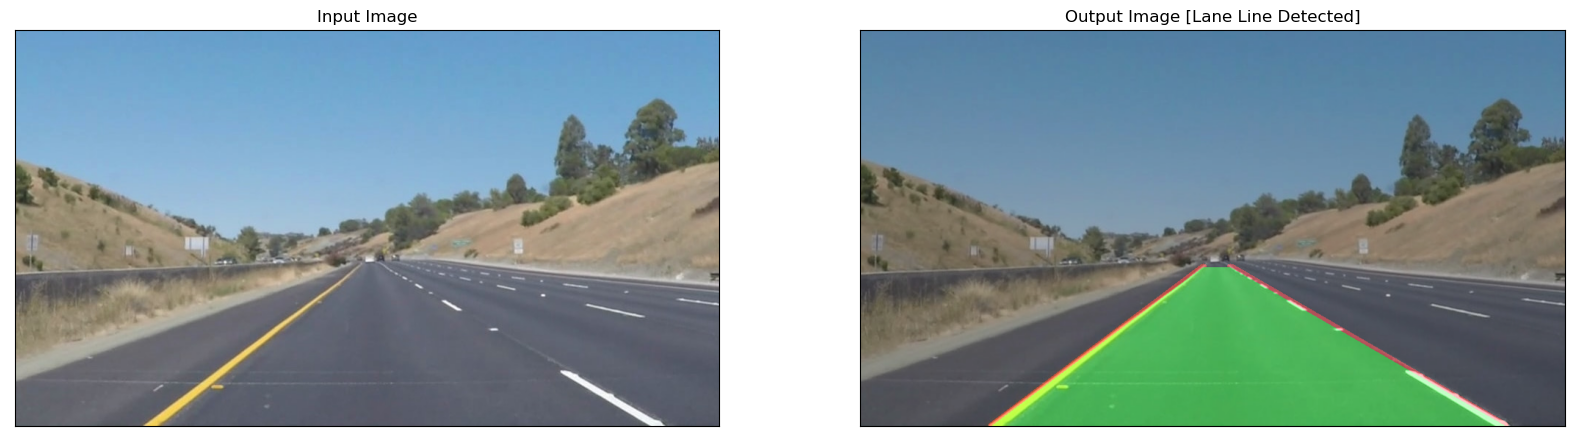

In [9]:
import os
for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()

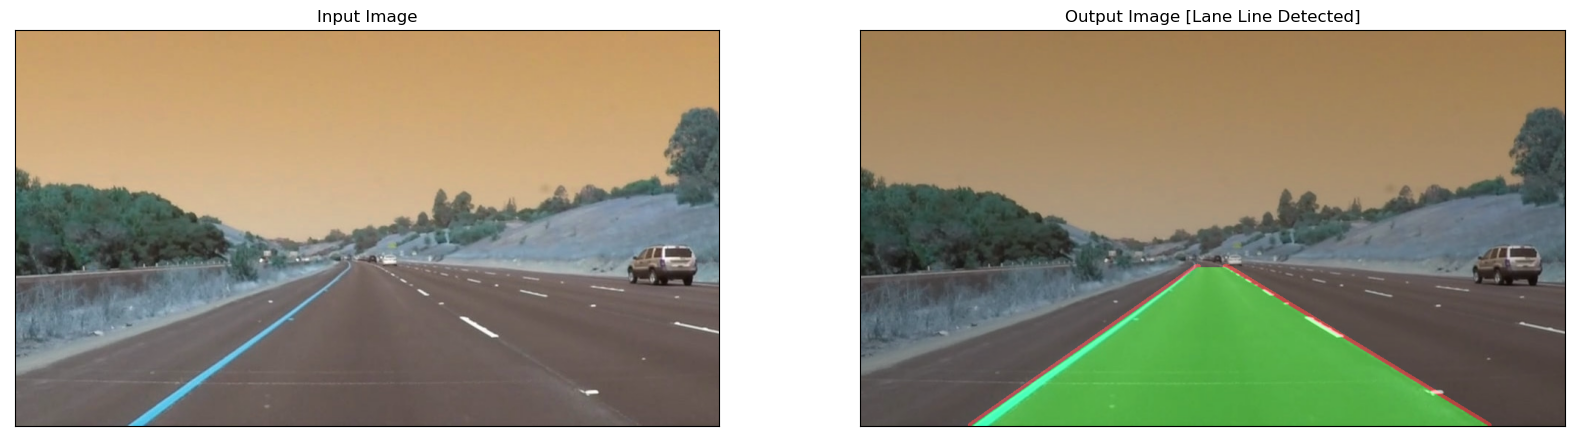

In [10]:
fig = plt.figure(figsize=(20, 10))

# Load and convert the image
image = mpimg.imread('/home/lorddeniz/Masaüstü/Road_lane/test_images/solidYellowCurve.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)

# Convert image to float64 for scaling
image = image.astype(np.float64)
image *= 255.0 / image.max() 
image = image.astype(np.uint8)  # Convert back to uint8

# Plot the input image
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(image)
ax.set_title("Input Image")

# Apply the lane finding pipeline
output_image = lane_finding_pipeline(image)

# Plot the output image
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(output_image)
ax.set_title("Output Image [Lane Line Detected]")

plt.show()

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip

In [15]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def slope_lines(image, lines):
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            
            if slope < 0:
                left_lines.append((slope, intercept))
            else:
                right_lines.append((slope, intercept))
    
    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)
    
    for slope, intercept in [left_line, right_line]:
        rows, cols = image.shape[:2]
        y1 = int(rows)  # image.shape[0]
        x1 = int((y1 - intercept) / slope)
        y2 = int(rows * 0.6)
        x2 = int((y2 - intercept) / slope)
        cv2.line(image, (x1, y1), (x2, y2), [9, 255, 0], 20)
    
    return image

def lane_finding_pipeline(image):
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img, kernel_size=5)
    canny_img = canny(blur_img, low_threshold=50, high_threshold=150)
    masked_img = region_of_interest(canny_img, get_vertices(image))
    lines = hough_lines(masked_img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=180)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img, lines)
    result_img = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
    return result_img

# Video dosyasının yolunu ve çıktı yolunu belirleyin
white_output = '/home/lorddeniz/Masaüstü/Road_lane/test_videos/solidWhiteRight.mp4'
clip1 = VideoFileClip("/home/lorddeniz/Masaüstü/Road_lane/test_videos/solidWhiteRight.mp4")

# Şerit bulma işlemini video üzerine uygulayın ve süreyi ölçün
white_clip = clip1.fl_image(lane_finding_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video /home/lorddeniz/Masaüstü/Road_lane/test_videos/solidWhiteRight.mp4.
Moviepy - Writing video /home/lorddeniz/Masaüstü/Road_lane/test_videos/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready /home/lorddeniz/Masaüstü/Road_lane/test_videos/solidWhiteRight.mp4
CPU times: user 6.99 s, sys: 8.48 s, total: 15.5 s
Wall time: 2.98 s


In [27]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def slope_lines(image, lines):
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # Skip vertical lines to avoid division by zero
            
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            
            if np.isnan(slope) or np.isnan(intercept):
                continue  # Skip NaN values
            
            if slope < 0:
                left_lines.append((slope, intercept))
            else:
                right_lines.append((slope, intercept))
    
    if left_lines:
        left_line = np.mean(left_lines, axis=0)
        x1_left = int((image.shape[0] - left_line[1]) / left_line[0])
        x2_left = int((image.shape[0] * 0.6 - left_line[1]) / left_line[0])
        cv2.line(image, (x1_left, image.shape[0]), (x2_left, int(image.shape[0] * 0.6)), [0, 255, 0], 20)
    
    if right_lines:
        right_line = np.mean(right_lines, axis=0)
        x1_right = int((image.shape[0] - right_line[1]) / right_line[0])
        x2_right = int((image.shape[0] * 0.6 - right_line[1]) / right_line[0])
        cv2.line(image, (x1_right, image.shape[0]), (x2_right, int(image.shape[0] * 0.6)), [0, 255, 0], 20)
    
    return image

def lane_finding_pipeline(image):
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img, kernel_size=5)
    canny_img = canny(blur_img, low_threshold=50, high_threshold=150)
    masked_img = region_of_interest(canny_img, get_vertices(image))
    lines = hough_lines(masked_img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=180)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    if lines is not None:  # Check if lines are found
        line_img = slope_lines(line_img, lines)
    
    result_img = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
    return result_img

yellow_output = '/home/lorddeniz/Masaüstü/Road_lane/test_videos/road1.mp4'

clip2 = VideoFileClip('/home/lorddeniz/Masaüstü/Road_lane/test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_finding_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)


t:   6%|██▌                                         | 40/675 [00:52<00:09, 70.50it/s, now=None]

Moviepy - Building video /home/lorddeniz/Masaüstü/Road_lane/test_videos/road1.mp4.
Moviepy - Writing video /home/lorddeniz/Masaüstü/Road_lane/test_videos/road1.mp4




t:   6%|██▌                                         | 40/675 [01:03<00:09, 70.50it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/lorddeniz/Masaüstü/Road_lane/test_videos/road1.mp4
CPU times: user 15.8 s, sys: 19.3 s, total: 35.2 s
Wall time: 11.6 s


In [28]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def slope_lines(image, lines):
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # Skip vertical lines to avoid division by zero
            
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            
            if np.isnan(slope) or np.isnan(intercept):
                continue  # Skip NaN values
            
            if slope < 0:
                left_lines.append((slope, intercept))
            else:
                right_lines.append((slope, intercept))
    
    if left_lines:
        left_line = np.mean(left_lines, axis=0)
        x1_left = int((image.shape[0] - left_line[1]) / left_line[0])
        x2_left = int((image.shape[0] * 0.6 - left_line[1]) / left_line[0])
        cv2.line(image, (x1_left, image.shape[0]), (x2_left, int(image.shape[0] * 0.6)), [0, 255, 0], 20)
    
    if right_lines:
        right_line = np.mean(right_lines, axis=0)
        x1_right = int((image.shape[0] - right_line[1]) / right_line[0])
        x2_right = int((image.shape[0] * 0.6 - right_line[1]) / right_line[0])
        cv2.line(image, (x1_right, image.shape[0]), (x2_right, int(image.shape[0] * 0.6)), [0, 255, 0], 20)
    
    return image

def lane_finding_pipeline(image):
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img, kernel_size=5)
    canny_img = canny(blur_img, low_threshold=50, high_threshold=150)
    masked_img = region_of_interest(canny_img, get_vertices(image))
    lines = hough_lines(masked_img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=180)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    if lines is not None:  # Check if lines are found
        line_img = slope_lines(line_img, lines)
    
    result_img = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
    return result_img

# Giriş ve çıkış dosya yollarını belirtin
input_video = '/home/lorddeniz/Masaüstü/Road_lane/test_videos/challenge.mp4'
output_video = '/home/lorddeniz/Masaüstü/Road_lane/test_videos/challenge_output.mp4'

# Video dosyasını yükleyin
clip = VideoFileClip(input_video)

# Şerit tespiti pipeline'ını uygulayın
processed_clip = clip.fl_image(lane_finding_pipeline)

# İşlenmiş videoyu kaydedin
processed_clip.write_videofile(output_video, audio=False, verbose=False)


t:   6%|██▌                                         | 40/675 [04:18<00:09, 70.50it/s, now=None]

Moviepy - Building video /home/lorddeniz/Masaüstü/Road_lane/test_videos/challenge_output.mp4.
Moviepy - Writing video /home/lorddeniz/Masaüstü/Road_lane/test_videos/challenge_output.mp4




t:   6%|██▌                                         | 40/675 [04:21<00:09, 70.50it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/lorddeniz/Masaüstü/Road_lane/test_videos/challenge_output.mp4


In [30]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def slope_lines(image, lines):
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # Skip vertical lines to avoid division by zero
            
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            
            if np.isnan(slope) or np.isnan(intercept):
                continue  # Skip NaN values
            
            if slope < 0:
                left_lines.append((slope, intercept))
            else:
                right_lines.append((slope, intercept))
    
    if left_lines:
        left_line = np.mean(left_lines, axis=0)
        x1_left = int((image.shape[0] - left_line[1]) / left_line[0])
        x2_left = int((image.shape[0] * 0.6 - left_line[1]) / left_line[0])
        cv2.line(image, (x1_left, image.shape[0]), (x2_left, int(image.shape[0] * 0.6)), [0, 255, 0], 20)
    
    if right_lines:
        right_line = np.mean(right_lines, axis=0)
        x1_right = int((image.shape[0] - right_line[1]) / right_line[0])
        x2_right = int((image.shape[0] * 0.6 - right_line[1]) / right_line[0])
        cv2.line(image, (x1_right, image.shape[0]), (x2_right, int(image.shape[0] * 0.6)), [0, 255, 0], 20)
    
    return image

def lane_finding_pipeline(image):
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img, kernel_size=5)
    canny_img = canny(blur_img, low_threshold=50, high_threshold=150)
    masked_img = region_of_interest(canny_img, get_vertices(image))
    lines = hough_lines(masked_img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=180)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    if lines is not None:  # Check if lines are found
        line_img = slope_lines(line_img, lines)
    
    result_img = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
    return result_img

# Giriş ve çıkış dosya yollarını belirtin
input_video = '/home/lorddeniz/Masaüstü/Road_lane/test_videos/solidYellowLeft.mp4'
output_video = '/home/lorddeniz/Masaüstü/Road_lane/test_videos/solidYellowLeft_output.mp4'

# Video dosyasını yükleyin
clip = VideoFileClip(input_video)

# Şerit tespiti pipeline'ını uygulayın
processed_clip = clip.fl_image(lane_finding_pipeline)

# İşlenmiş videoyu kaydedin
processed_clip.write_videofile(output_video, audio=False, verbose=False)


                                                                                               
t:   6%|██▌                                         | 40/675 [06:23<00:09, 70.50it/s, now=None]
                                                                                               
t:  20%|████████▎                                 | 215/1084 [01:10<00:31, 27.75it/s, now=None]

Moviepy - Building video /home/lorddeniz/Masaüstü/Road_lane/test_videos/solidYellowLeft_output.mp4.
Moviepy - Writing video /home/lorddeniz/Masaüstü/Road_lane/test_videos/solidYellowLeft_output.mp4





t:   0%|                                                     | 0/675 [00:00<?, ?it/s, now=None]

t:   1%|▍                                            | 6/675 [00:00<00:11, 56.55it/s, now=None]

t:   2%|▊                                           | 12/675 [00:00<00:11, 58.47it/s, now=None]

t:   3%|█▏                                          | 18/675 [00:00<00:11, 57.61it/s, now=None]

t:   4%|█▋                                          | 25/675 [00:00<00:10, 61.26it/s, now=None]

t:   5%|██                                          | 32/675 [00:00<00:10, 60.43it/s, now=None]

t:   6%|██▌                                         | 39/675 [00:00<00:10, 62.85it/s, now=None]

t:   7%|███▏                                        | 48/675 [00:00<00:10, 58.78it/s, now=None]

t:   8%|███▋                                        | 56/675 [00:00<00:09, 62.64it/s, now=None]

t:   9%|████                                        | 63/675 [00:01<00:09, 63.65it/s, now=None]

t:  10%|████▌               

Moviepy - Done !
Moviepy - video ready /home/lorddeniz/Masaüstü/Road_lane/test_videos/solidYellowLeft_output.mp4
